사전 학습(pre-trained) 모델의 검증된 아키텍처와 가중치를 그대로 가져오고, 일부 새로운 층을 추가하거나 가중치를 조정하는 방식으로 학습하는 것을 전이 학습(Transfer Learning)이라고 말한다.

모델의 구조가 복잡하거나 입력 데이터의 개수가 많아지면 구글 코랩의 디폴트 환경인 CPU 런타임에서는 모델 학습이 느리게 된다.

GPU를 사용하자.

하드웨어 가속기 옵션 중 하나임.

In [2]:
#CIFAR-10 데이터셋
#10개의 클래스(비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭)를 갖는 학습용 이미지 분류 데이터

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape
from tensorflow.keras.layers import BatchNormalization

SEED=12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [3]:
#5만 개의 훈련 데이터와 1만개의 검증 데이터로 구성됨
#각 이미지는 32*32 크기, 컬러이미지이므로 3채널(RGB)로 구성돔
#이미지 픽셀 값은 0~255 범위이기 때문에 255로 나누면 정규화 변환

from tensorflow.keras import datasets
cifar10 = datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#피쳐 스케일링
X_train = X_train / 255.
X_test = X_test / 255.

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

170498071/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


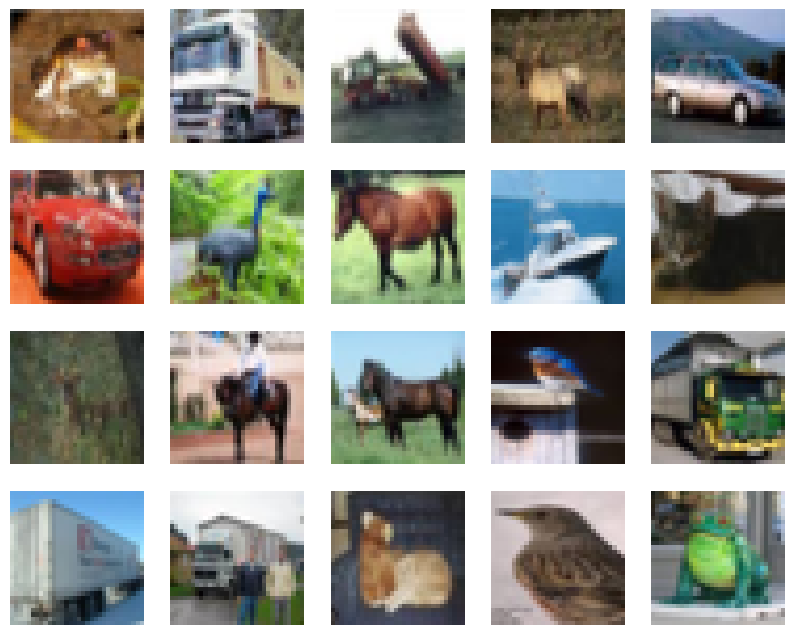

In [4]:
#학습용 데이터에 들어 있는 첫20개 이미지를 출력해서 확인하자.
plt.figure(figsize=(10,8))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(X_train[i])
  plt.axis('off')
plt.show()

In [5]:
#일반 합성곱 신경망 CNN으로 분류예측
#전이 학습과 비교하기 위해 일반적인 합성곱 신경망 모델을 정의하자.
#다중 분류 모델이므로 마지막 출력 레이어의 활성화 함수는 softmax, 손실 함수로는 범주형 교차 엔트로피
#목표 레이블이 원핫 인코딩 처리 없이 1개의 열에 0 1 2 .. 9 로 입력되어 있기 때문에 categorical_crossentropy 대신 sparse_categorical_crossentropy 사용
#보조 지표로 정확도를 나타내는 accuracy 사용

def build_cnn():
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5),strides=(2,2),
                   activation = 'relu',input_shape=[32,32,3]))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters=64,kernel_size = (5,5), strides=(2,2),
                   activation ='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=64, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(units=32, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(units=10, activation='softmax'))
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model
cnn_model = build_cnn()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        2432      
                                                                 
 batch_normalization (Batch  (None, 14, 14, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          51264     
                                                                 
 batch_normalization_1 (Bat  (None, 2, 2, 64)          256       
 chNormalization)                                                
                                                        

In [6]:
#모델 학습
cnn_history = cnn_model.fit(X_train, y_train, batch_size = 256, epochs=20,
                            validation_split=0.1, verbose=0)


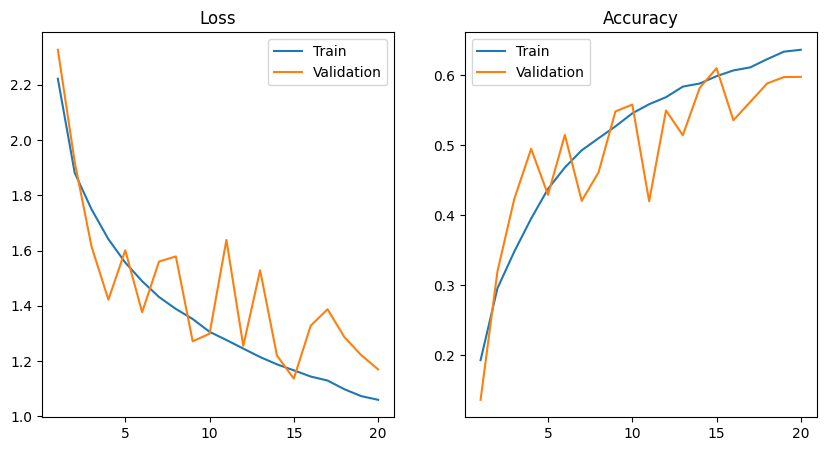

In [7]:
#20 에포크까지 손실 함수와 정확도를 그래프로 나타내는 함수
def plot_metrics(history, start=1, end=20):
  fig, axes = plt.subplots(1,2,figsize=(10,5))
  #loss:손실 함수
  axes[0].plot(range(start, end+1), history.history['loss'][start-1:end],
               label='Train')
  axes[0].plot(range(start, end+1), history.history['val_loss'][start-1:end],
               label='Validation')
  axes[0].set_title('Loss')
  axes[0].legend()

  #Accuracy
  axes[1].plot(range(start, end+1), history.history['accuracy'][start-1:end],
               label = 'Train')
  axes[1].plot(range(start, end+1), history.history['val_accuracy'][start-1:end],
               label = 'Validation')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  plt.show()

plot_metrics(history=cnn_history, start=1, end=20)

이미 수많은 이미지 데이터를 학습한 사전 학습 모델을 활욜하면 더 빠르게 안정적인 학습 결과를 얻을 수 있다. ResNet50이라는 사전 학습 모델을 활용하자

사전 학습 모델을 가져올 때 include_top옵션을 False로 지정하면 모델의 분류기 역할을 하는 부분을 제외하고 가져온다.
weights옵션에 지정한 imagenet은 ImageNet 데이터로 학습한 가중치를 가져온다는 뜻이다.
입력 크기과 분류 클래스 개수를 지정한다.

Flatten레이어를 사용하여 cnn_base 모델의 출력층을 1차원 배열로 변환하고 MLP모델에 연결하여 최종 분류 모델을 완성하자.
ResNet50이 복잡한 형태의 모델이므로 과대적합 방지를 위해 완전 연결 신경망에 dropout을 추가함.

In [8]:
#pre-trained 모델 가져오기
from tensorflow.keras.applications import ResNet50
cnn_base = ResNet50(include_top = False, weights='imagenet',
                    input_shape=[32,32,3], classes=10)
#transfer 모델 생성
def build_transfer():
  transfer_model = Sequential()
  transfer_model.add(cnn_base)
  transfer_model.add(Flatten())

  transfer_model.add(Dense(units=64, activation='relu'))
  transfer_model.add(Dropout(rate=0.5))
  transfer_model.add(Dense(units=32, activation='relu'))
  transfer_model.add(Dropout(rate=0.5))
  transfer_model.add(Dense(units=10,activation='softmax'))

  transfer_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
  return transfer_model
transfer_model = build_transfer()
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                131136    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 10)               

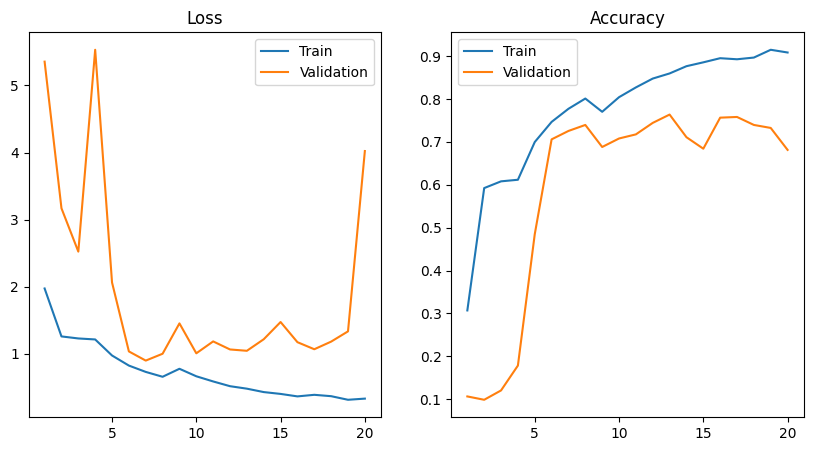

In [9]:
tm_history = transfer_model.fit(X_train,y_train,batch_size=256, epochs=20,
                                validation_split=0.1,verbose=0)
plot_metrics(history=tm_history,start=1,end=20)

앞에서 단순 합성곱 신경망을 적용했을 때보다 모델 학습 과정이 안정적으로 보인다.

검증 정확도를 보니 50~60퍼 수준에서 70% 수준으로 향상되었지만

10에포크를 지나면서 모델이 과대적합 경향을 보이기 때문에 피할 수 있는 방법을 고려해야 한다.